## Import Packages

In [155]:
#General packages
import pandas as pd
import numpy as np
import time
import glob
import pickle
import collections
import warnings
warnings.filterwarnings('ignore')

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

#NLP packages
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud

#Text preprocessing packages
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Classification metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#Feature Selection packages
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.decomposition import PCA

#Sampling package
from sklearn.utils import resample

#SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



In [156]:
#Set display options
%matplotlib inline
rcParams['figure.figsize'] = 10, 6

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Data Wrangling

There are totally 50,000 reviews split evenly into 25k train and 25k test sets with balanced distribution of labels (12500 positive and 12500 negative reviews in each set). Reviews are stored in text files named following the convention [[id]_[rating].txt] where [id] is a unique id and [rating] is the star rating for that review on a 1-10 scale. A review is labeled negative if it has a score <= 4 out of 10, and positive if it has a score >= 7 out of 10. Reviews with more neutral ratings are not included in the train/test sets. 
Review text from each file into Pandas Dataframe imdb_train & imdb_test. Reviews read from "pos" folder are labeled 1 and "neg" folder is labeled 0. Rating information from the filenames is also extracted and stored in a column for validation. 

In [157]:
#Read negative and positive training reviews into train dataframe
#Add a column to label positive reviews as 1 and negative reviews as 0
train_pos_filenames = glob.glob("/Users/aru/DataScience/Projects/IMDB-Sentiment_Analysis/aclImdb/train/pos/*.txt")
train_neg_filenames = glob.glob("/Users/aru/DataScience/Projects/IMDB-Sentiment_Analysis/aclImdb/train/neg/*.txt")

pos_reviews = []
neg_reviews = []
rating = []

#User-defined function that extracts the rating from the file name and reads the reviews
#Returns a dataframe with review, rating and label columns
def read_file(filenames,label):
    reviews = []
    rating = []
    for file in filenames:
        if file[-6] == '1':
            rating.append(10)
        else:
            rating.append(file[-5])
        with open(file) as f:
            text = f.read()
            reviews.append(text)
    df = pd.DataFrame(reviews, columns=['review'])
    df['rating'] = list(map(int, rating))
    df['label'] = label
    return df

imdb_pos_train = read_file(train_pos_filenames, 1)
imdb_neg_train = read_file(train_neg_filenames, 0)
#Combine both dataframes to form one training dataframe
imdb_train = pd.concat([imdb_pos_train, imdb_neg_train], ignore_index=True )

#Read negative and positive testing reviews into test dataframe
#Add a column to label positive reviews as 1 and negative reviews as 0
test_pos_filenames = glob.glob("/Users/aru/DataScience/Projects/IMDB-Sentiment_Analysis/aclImdb/test/pos/*.txt")
test_neg_filenames = glob.glob("/Users/aru/DataScience/Projects/IMDB-Sentiment_Analysis/aclImdb/test/neg/*.txt")

imdb_pos_test = read_file(test_pos_filenames, 1)
imdb_neg_test = read_file(test_neg_filenames, 0)
#Combine both dataframes to form one training dataframe
imdb_test = pd.concat([imdb_pos_test, imdb_neg_test], ignore_index=True )

After reading the reviews from the files, we have two dataframes, imdb_train & imdb_test with the following columns,   
*review* : Review text   
*rating* : Rating information extracted from the filename, ranges from 1-4 & 7-10   
*label* : Positive reviews - 1 and Negative reviews - 0   

In [158]:
imdb_train.head()

,review,rating,label
0,For a movie that gets no respect there sure ar...,9,1
1,Bizarre horror movie filled with famous faces ...,8,1
2,"A solid, if unremarkable film. Matthau, as Ein...",7,1
3,It's a strange feeling to sit alone in a theat...,8,1
4,"You probably all already know this by now, but...",10,1


In [159]:
imdb_test.head()

,review,rating,label
0,"Based on an actual story, John Boorman shows t...",9,1
1,This is a gem. As a Film Four production - the...,9,1
2,"I really like this show. It has drama, romance...",9,1
3,This is the best 3-D experience Disney has at ...,10,1
4,"Of the Korean movies I've seen, only three had...",10,1


In [160]:
#Shuffle the rows of train and test 
imdb_train = imdb_train.sample(frac=1).reset_index(drop=True)
imdb_test = imdb_test.sample(frac=1).reset_index(drop=True)

### 1.1 Text Preprocessing
Review column undergoes a series of text preprocessing like removal of numbers and symbols, word tokenizer, stop word removal and lemmatization. NLP package is used to see the step wise changes to review column. 

User defined functions to normalize the review and combine lemmas together to form a continuous string. 

In [161]:
#Remove unwanted characters and normalize the text
def normalize_text(text):
    """ Input: Review document, one review at a time
        Output: Cleaned review text after removing numbers and special characters"""
    norm_text = text.lower()
    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')
    #Pad punctuation with spaces on both sides
    norm_text = re.sub(r"([\.\"\(\)\-!\?;:',0-9_~])", "" , norm_text)
    return norm_text

#Reconstruct the review sentences from lemmatized words to give as input to CountVectorizer
def combine_lemmas(lemma):
    """ Input: Lemmatized tokens
        Output: tokens are combined back to strings"""
    reconstructed_rev = ' '.join(lemma)
    return reconstructed_rev

In [162]:
eng_stopwords = stopwords.words('english') 
wl = WordNetLemmatizer()
s = PorterStemmer()

In [163]:
#Apply normalize_text() to train and test dataset
imdb_train['norm_review'] = imdb_train['review'].apply(normalize_text)
imdb_test['norm_review'] = imdb_test['review'].apply(normalize_text)

#Apply word tokenizer to train and test dataset
imdb_train['word_tokens'] = imdb_train['norm_review'].apply(word_tokenize)
imdb_test['word_tokens'] = imdb_test['norm_review'].apply(word_tokenize)

#Remove stopwords in train and test dataset
imdb_train['no_stop_words'] = imdb_train['word_tokens'].apply(
    lambda x: [word for word in x if word not in eng_stopwords])
imdb_test['no_stop_words'] = imdb_test['word_tokens'].apply(
    lambda x: [word for word in x if word not in eng_stopwords])

#Lemmatization in train and test dataset
imdb_train['word_lemma'] = imdb_train['no_stop_words'].apply(
     lambda y: [wl.lemmatize(word, pos='v') for word in y])
imdb_test['word_lemma'] = imdb_test['no_stop_words'].apply(
     lambda y: [wl.lemmatize(word, pos='v') for word in y])

In [164]:
#reconstruct the reviews by combining the lemmas using user-defined function combine_lemma
imdb_train['review_lemma'] = imdb_train['word_lemma'].apply(combine_lemmas)

imdb_test['review_lemma'] = imdb_test['word_lemma'].apply(combine_lemmas)

In [183]:
#Turn off pretty printing for horizontal printing of lists
%pprint
#Let us see an example of what normalize_text() does

#Below we select the review from the train dataset with maximum length
imdb_train['review'][imdb_train['review'].apply(len).idxmax()]

Pretty printing has been turned OFF


'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

In [184]:
#Apply normalize_text() to the review with maximum length
normalize_text(imdb_train['review'][imdb_train['review'].apply(len).idxmax()])

'match  tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit according to the rules of the match both opponents have to go through tables in order to get the win benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray a german suplex by benoit to bubba took the wind out of the dudley brother spike tried to help his brother but the referee restrained him while benoit and guerrero ganged up on him in the corner with benoit stomping away on bubba guerrero set up a table outside spike dashed into the ring and somersaulted over the top rope onto guerrero on the outside after recovering and taking care of spike guerrero slipped a table into the ring and helped the wolverine set it up the tandem then set up for a double superplex from the middle rope which would have put bubba through the table but spike knocked

In [185]:
#Example of word tokenization
word_tokenize(imdb_train['norm_review'][500])

['i', 'am', 'curious', 'yellow', 'is', 'a', 'risible', 'and', 'pretentious', 'steaming', 'pile', 'it', 'doesnt', 'matter', 'what', 'ones', 'political', 'views', 'are', 'because', 'this', 'film', 'can', 'hardly', 'be', 'taken', 'seriously', 'on', 'any', 'level', 'as', 'for', 'the', 'claim', 'that', 'frontal', 'male', 'nudity', 'is', 'an', 'automatic', 'nc', 'that', 'isnt', 'true', 'ive', 'seen', 'rrated', 'films', 'with', 'male', 'nudity', 'granted', 'they', 'only', 'offer', 'some', 'fleeting', 'views', 'but', 'where', 'are', 'the', 'rrated', 'films', 'with', 'gaping', 'vulvas', 'and', 'flapping', 'labia', 'nowhere', 'because', 'they', 'dont', 'exist', 'the', 'same', 'goes', 'for', 'those', 'crappy', 'cable', 'shows', 'schlongs', 'swinging', 'in', 'the', 'breeze', 'but', 'not', 'a', 'clitoris', 'in', 'sight', 'and', 'those', 'pretentious', 'indie', 'movies', 'like', 'the', 'brown', 'bunny', 'in', 'which', 'were', 'treated', 'to', 'the', 'site', 'of', 'vincent', 'gallos', 'throbbing', 'j

In [186]:
#Example of stop word removal
[word for word in imdb_train['word_tokens'][500] if word not in eng_stopwords]

['curious', 'yellow', 'risible', 'pretentious', 'steaming', 'pile', 'doesnt', 'matter', 'ones', 'political', 'views', 'film', 'hardly', 'taken', 'seriously', 'level', 'claim', 'frontal', 'male', 'nudity', 'automatic', 'nc', 'isnt', 'true', 'ive', 'seen', 'rrated', 'films', 'male', 'nudity', 'granted', 'offer', 'fleeting', 'views', 'rrated', 'films', 'gaping', 'vulvas', 'flapping', 'labia', 'nowhere', 'dont', 'exist', 'goes', 'crappy', 'cable', 'shows', 'schlongs', 'swinging', 'breeze', 'clitoris', 'sight', 'pretentious', 'indie', 'movies', 'like', 'brown', 'bunny', 'treated', 'site', 'vincent', 'gallos', 'throbbing', 'johnson', 'trace', 'pink', 'visible', 'chloe', 'sevigny', 'crying', 'implying', 'doublestandard', 'matters', 'nudity', 'mentally', 'obtuse', 'take', 'account', 'one', 'unavoidably', 'obvious', 'anatomical', 'difference', 'men', 'women', 'genitals', 'display', 'actresses', 'appears', 'nude', 'said', 'man', 'fact', 'generally', 'wont', 'see', 'female', 'genitals', 'american

In [187]:
#Example of lemmatization
[wl.lemmatize(word, pos='v') for word in imdb_train['no_stop_words'][500]]

['curious', 'yellow', 'risible', 'pretentious', 'steam', 'pile', 'doesnt', 'matter', 'ones', 'political', 'view', 'film', 'hardly', 'take', 'seriously', 'level', 'claim', 'frontal', 'male', 'nudity', 'automatic', 'nc', 'isnt', 'true', 'ive', 'see', 'rrated', 'film', 'male', 'nudity', 'grant', 'offer', 'fleet', 'view', 'rrated', 'film', 'gap', 'vulvas', 'flap', 'labia', 'nowhere', 'dont', 'exist', 'go', 'crappy', 'cable', 'show', 'schlongs', 'swing', 'breeze', 'clitoris', 'sight', 'pretentious', 'indie', 'movies', 'like', 'brown', 'bunny', 'treat', 'site', 'vincent', 'gallos', 'throb', 'johnson', 'trace', 'pink', 'visible', 'chloe', 'sevigny', 'cry', 'imply', 'doublestandard', 'matter', 'nudity', 'mentally', 'obtuse', 'take', 'account', 'one', 'unavoidably', 'obvious', 'anatomical', 'difference', 'men', 'women', 'genitals', 'display', 'actresses', 'appear', 'nude', 'say', 'man', 'fact', 'generally', 'wont', 'see', 'female', 'genitals', 'american', 'film', 'anything', 'short', 'porn', 'e

In [188]:
#Example of word stemming
[s.stem(word) for word in imdb_train['word_lemma'][500]]

['curiou', 'yellow', 'risibl', 'pretenti', 'steam', 'pile', 'doesnt', 'matter', 'one', 'polit', 'view', 'film', 'hardli', 'take', 'serious', 'level', 'claim', 'frontal', 'male', 'nuditi', 'automat', 'nc', 'isnt', 'true', 'ive', 'see', 'rrate', 'film', 'male', 'nuditi', 'grant', 'offer', 'fleet', 'view', 'rrate', 'film', 'gap', 'vulva', 'flap', 'labia', 'nowher', 'dont', 'exist', 'go', 'crappi', 'cabl', 'show', 'schlong', 'swing', 'breez', 'clitori', 'sight', 'pretenti', 'indi', 'movi', 'like', 'brown', 'bunni', 'treat', 'site', 'vincent', 'gallo', 'throb', 'johnson', 'trace', 'pink', 'visibl', 'chloe', 'sevigni', 'cri', 'impli', 'doublestandard', 'matter', 'nuditi', 'mental', 'obtus', 'take', 'account', 'one', 'unavoid', 'obviou', 'anatom', 'differ', 'men', 'women', 'genit', 'display', 'actress', 'appear', 'nude', 'say', 'man', 'fact', 'gener', 'wont', 'see', 'femal', 'genit', 'american', 'film', 'anyth', 'short', 'porn', 'explicit', 'erotica', 'alleg', 'doublestandard', 'less', 'doubl

In [189]:
#Turn on pretty printing back
%pprint

Pretty printing has been turned ON


# 2. EDA

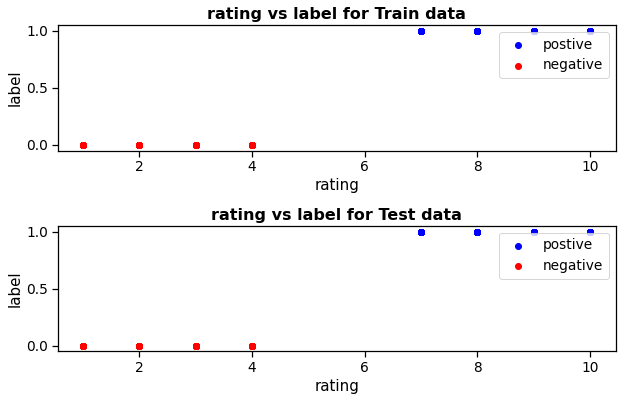

In [190]:
#Verify that all ratings <= 4 is labeled 0 and >= 7 is labeled 1
plt.subplot(2,1,1)
plt.scatter('rating', 'label', data=imdb_train[imdb_train['label'] == 1], c='b', label='postive')
plt.scatter('rating', 'label', data=imdb_train[imdb_train['label'] == 0], c='r', label='negative')
plt.title('rating vs label for Train data',fontsize=16, fontweight='bold')
plt.xlabel('rating')
plt.ylabel('label')
plt.legend()

plt.subplot(2,1,2)
plt.scatter('rating', 'label', data=imdb_test[imdb_test['label'] == 1], c='b', label='postive')
plt.scatter('rating', 'label', data=imdb_test[imdb_test['label'] == 0], c='r',label='negative')
plt.title('rating vs label for Test data',fontsize=16, fontweight='bold')
plt.xlabel('rating')
plt.ylabel('label')
plt.legend()

plt.subplots_adjust(hspace=0.6)
plt.show()

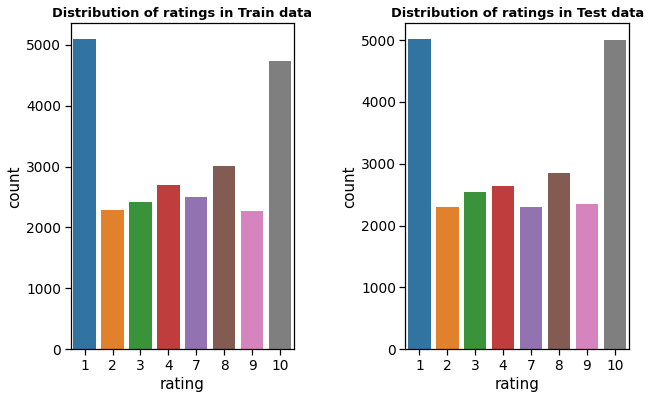

In [191]:
#Plot the distribution of ratings in Train and test data
plt.subplot(1,2,1)
sns.countplot(x= 'rating', data = imdb_train)
plt.title('Distribution of ratings in Train data',fontsize=13, fontweight='bold')

plt.subplot(1,2,2)
sns.countplot(x= 'rating', data = imdb_test)
plt.title('Distribution of ratings in Test data',fontsize=13, fontweight='bold')

plt.subplots_adjust(wspace=0.5)
plt.show()

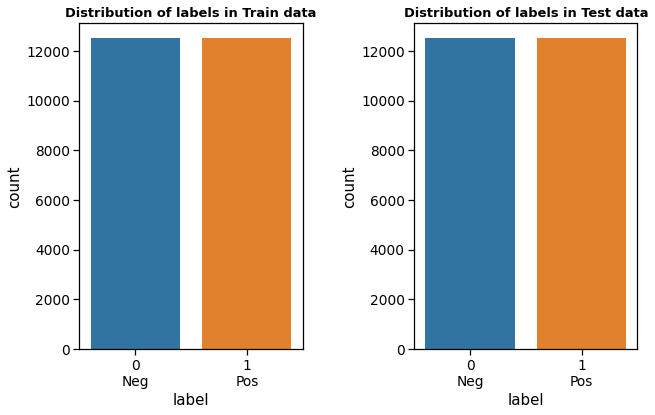

In [192]:
#Distrubution of positive and negative reviews in Train set
plt.subplot(1,2,1)
sns.countplot(x= 'label', data = imdb_train)
plt.title('Distribution of labels in Train data',fontsize=13, fontweight='bold')
plt.xticks([0,1],["0\nNeg", "1\nPos"])

plt.subplot(1,2,2)
sns.countplot(x= 'label', data = imdb_test)
plt.title('Distribution of labels in Test data',fontsize=13, fontweight='bold')
plt.xticks([0,1],["0\nNeg", "1\nPos"])

plt.subplots_adjust(wspace=0.5)
plt.show()

User defined function visualize_reviews() is used to plot 20 most common unigrams and bigrams in both the classes of train dataset 

In [193]:
#Plot 20 most common words & display word count
def visualize_reviews(count_data, count_vectorizer, wordcloud_flag):
    words = count_vectorizer.get_feature_names()
    word_count = count_data.toarray().sum(axis=0)
    wordCount_df = pd.DataFrame(words, columns=['Word'])
    wordCount_df['Count'] = word_count
    wordCount_df.sort_values(by=['Count'], ascending=False, inplace=True)
    x_pos = np.arange(len(wordCount_df['Word'][0:20])) 
    
    plt.figure(2, figsize=(12, 12/1.6180))
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(wordCount_df['Word'][0:20], wordCount_df['Count'][0:20], palette='husl')
    plt.xticks(x_pos, wordCount_df['Word'][0:20], rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
    if wordcloud_flag == 1:
        #Display word cloud
        rev = ' '.join(wordCount_df['Word'].values)
        stopwords = set(eng_stopwords)
        wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(rev)
        plt.figure(figsize = (10, 8), facecolor = None) 
        plt.title("Word Cloud",fontsize=13, fontweight='bold')
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 

Plot of 20 most common unigrams and bigrams shows that bigrams provides more context about the review classes. We will include both unigrams & bigrams in our models.

Top 20 unigrams in positive reviews:


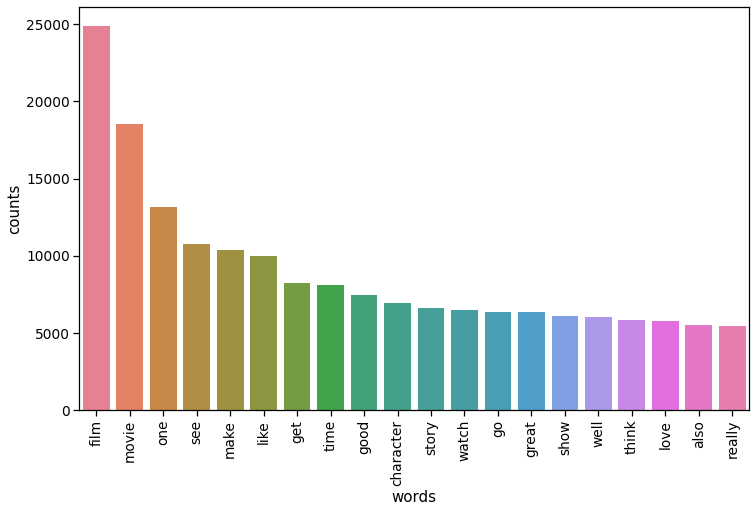

Top 20 bigrams in positive reviews:


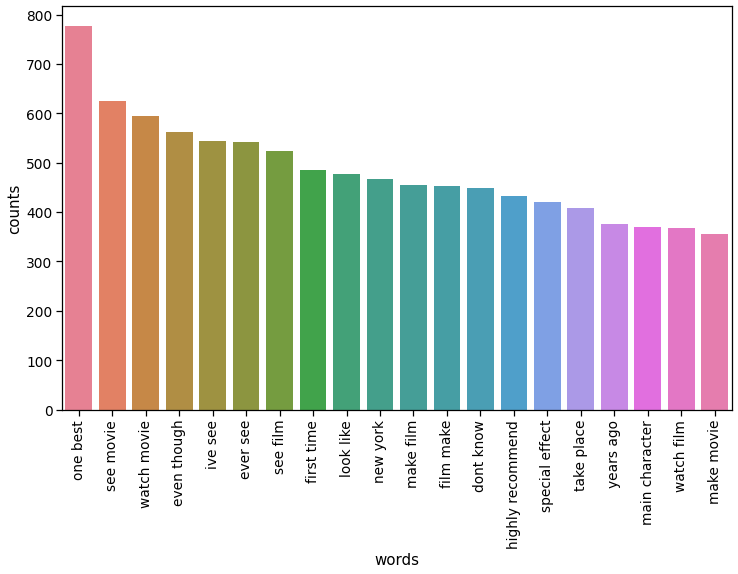

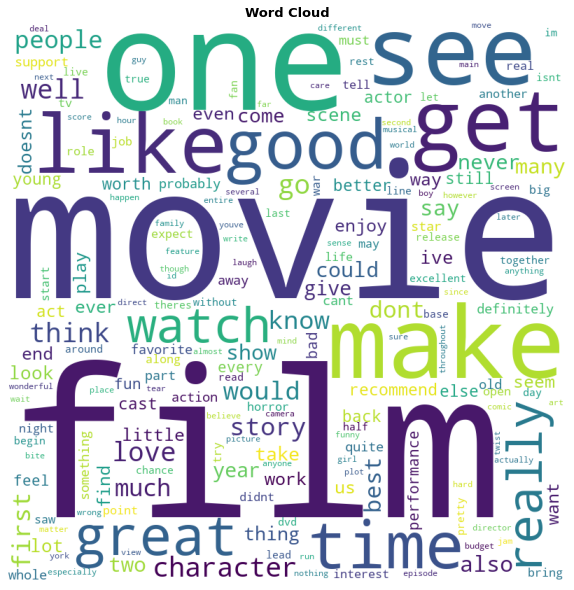

In [194]:
#separate the positive and negative reviews in train data using filters
pos = imdb_train['label'] == 1
neg = imdb_train['label'] == 0

#Display top 20 unigrams for positive reviews
print("Top 20 unigrams in positive reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(1,1))
pos_rev_vect = count_vect.fit_transform(imdb_train[pos].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=0)

#Display top 20 bigrams for positive reviews
print("Top 20 bigrams in positive reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(2,2))
pos_rev_vect = count_vect.fit_transform(imdb_train[pos].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=1)

Top 20 unigrams in negative reviews:


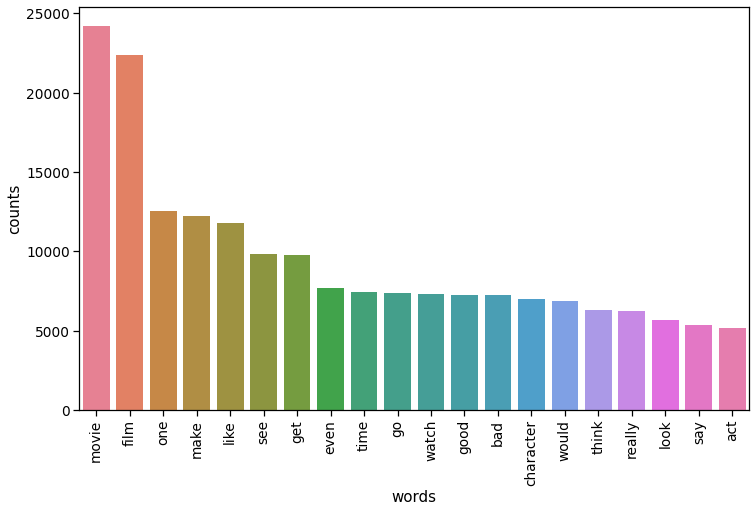

Top 20 bigrams in negative reviews:


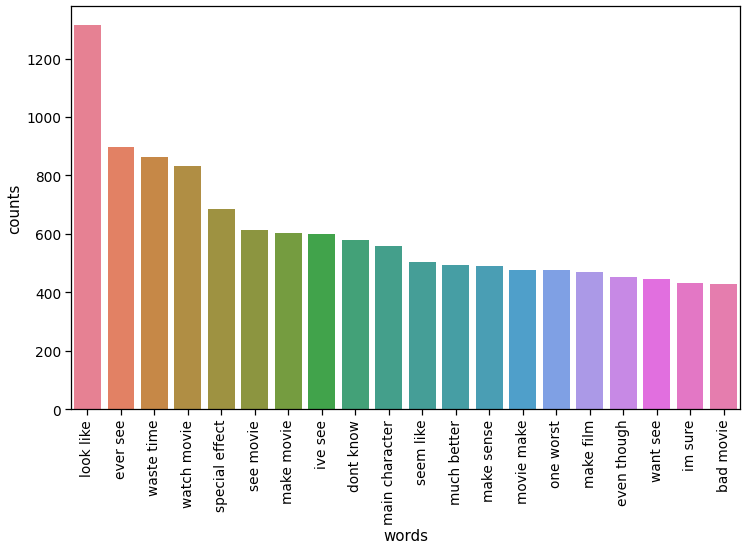

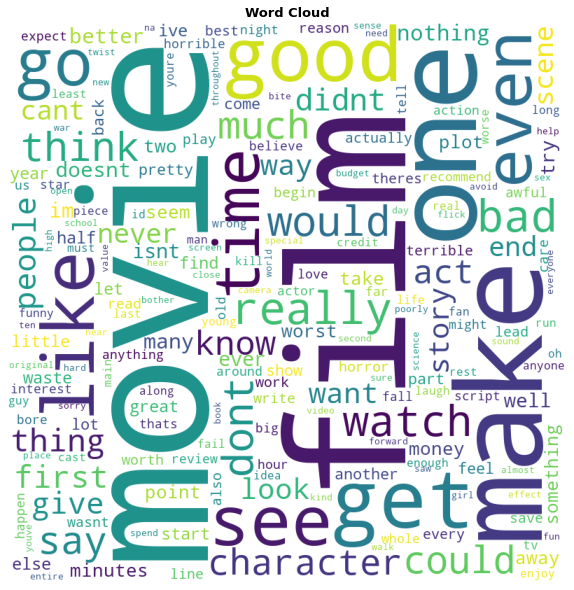

In [195]:
#Display top 20 unigrams for negative reviews
print("Top 20 unigrams in negative reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(1,1))
pos_rev_vect = count_vect.fit_transform(imdb_train[neg].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=0)

#Display top 20 bigrams for negative reviews
print("Top 20 bigrams in negative reviews:")
count_vect = CountVectorizer(min_df=50, ngram_range=(2,2))
pos_rev_vect = count_vect.fit_transform(imdb_train[neg].review_lemma.values)
visualize_reviews(pos_rev_vect, count_vect, wordcloud_flag=1)

# 3. Count Vectorizer

In [196]:
#Fit CountVectorizer() and TfidfTransformer() to Train set, and transform the Test set
count_vect = CountVectorizer(min_df = 50, ngram_range=(1,2))
X_train_cv = count_vect.fit_transform(imdb_train['review_lemma'].values)
X_test_cv = count_vect.transform(imdb_test['review_lemma'].values)

tfidf_vect = TfidfTransformer()
X_train = tfidf_vect.fit_transform(X_train_cv)
X_test = tfidf_vect.transform(X_test_cv)

y_train = imdb_train['label'].values
y_test = imdb_test['label'].values

In [197]:
print("Number of features generated for our Classification model after CountVectorizer: ", X_train_cv.shape[1])

Number of features generated for our Classification model after CountVectorizer:  7957


In [198]:
print("Shape of Train dataset", X_train.shape)
print("Shape of Test dataset", X_test.shape)

Shape of Train dataset (25000, 7957)
Shape of Test dataset (25000, 7957)


# 4. Classification Models Comparison

### Utility Functions

In [200]:
#Calculate model metrics and append to modelScore_list
modelScore_list = []

def model_score(name, y_pred, y_pred_prob, fit_time, pred_time, modelScore_list):
    accuracy = accuracy_score(y_pred, y_test) * 100
    roc_auc = roc_auc_score(y_test, y_pred_prob) * 100
    f1_1 = f1_score(y_test, y_pred, pos_label = 1)
    f1_0 = f1_score(y_test, y_pred, pos_label = 0)
    prec_1 = precision_score(y_test, y_pred, pos_label=1)
    prec_0 = precision_score(y_test, y_pred, pos_label=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1)
    rec_0 = recall_score(y_test, y_pred, pos_label=0)
    modelScore_list = modelScore_list.append([name, accuracy, roc_auc, f1_1, prec_1, rec_1,
                                              f1_0, prec_0, rec_0, fit_time, pred_time])
    return modelScore_list

#Plot precision vs threshold & Recall vs threshold for both the labels
def threshold_cfm(y_pred_prob):
    prec1 = []
    prec0 = []
    rec1 = []
    rec0 = []
    f1_1 = []
    f1_0 = []
    
    threshold_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    pred_proba_df = pd.DataFrame(y_pred_prob)
    for i in threshold_list:
        y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
        y_test_pred = y_test_pred.to_numpy()
        
        prec1.append(precision_score(y_test, y_test_pred, pos_label=1))
        prec0.append(precision_score(y_test, y_test_pred, pos_label=0))
        rec1.append(recall_score(y_test, y_test_pred, pos_label=1))
        rec0.append(recall_score(y_test, y_test_pred, pos_label=0))
        f1_1.append(f1_score(y_test, y_test_pred, pos_label = 1))
        f1_0.append(f1_score(y_test, y_test_pred, pos_label = 0))
        
        
    plt.plot(threshold_list,prec1, label = 'prec-pos')
    plt.plot(threshold_list,prec0, label = 'prec-neg')
    
    plt.plot(threshold_list, rec1, label = 'rec-pos')
    plt.plot(threshold_list, rec0, label = 'rec-neg')
    
    plt.plot(threshold_list,f1_1, label = 'f1-pos')
    plt.plot(threshold_list,f1_0, label = 'f1-neg')
    plt.legend()
    plt.show()
    
def prob_dist(y_pred_prob):
    pred_proba_df = pd.DataFrame(list(zip(y_pred_prob, y_test)) , columns=['pred_prob', 'label'])
    sns.distplot(pred_proba_df[pred_proba_df['label'] == 1].pred_prob, label='Positive Reviews')
    sns.distplot(pred_proba_df[pred_proba_df['label'] == 0].pred_prob, label='Negative Reviews')
    plt.legend()
    
    
#3-fold Cross-Validation function in order to understand each paramters influence on the dataset
import math 
from scipy.sparse import vstack

def cross_val_3(train, label, score_list, model_name, p):
    len_df = train.shape[0]
    size = math.floor(len_df/3)

    #Split the feature dataset into 3 folds
    t1 = train[:size]
    t2 = train[size : 2*size]
    t3 = train[2*size:]
    
    #Split the label dataset into 3 folds
    l1 = label[:size]
    l2 = label[size : 2*size]
    l3 = label[2*size:]
    
    #Form train and test sets for cross-validation
    #vstack function is used to concatenate sparse matrix output from CountVectorizer
    train1 = vstack([t1, t2])
    test1 = t3
    tr_label1 = np.concatenate((l1, l2), axis=None)
    t_label1 = l3
    score = model(train1, tr_label1, test1, t_label1, model_name, p)
    score_list.append(score)
    
    train2 = vstack([t1, t3])
    test2 = t2
    tr_label2 = np.concatenate((l1, l3), axis=None)
    t_label2 = l2
    score = model(train2, tr_label2, test2, t_label2, model_name, p)
    score_list.append(score)
    
    train3 = vstack([t2, t3])
    test3 = t1
    tr_label3 = np.concatenate((l2, l3), axis=None)
    t_label3 = l1
    score = model(train3, tr_label3, test3, t_label3, model_name, p)
    score_list.append(score)
    return

#Define models
def model(train, train_label, test, test_label, model_name, params):
    if model_name == 'LogReg':
        return LogRegModel(train, train_label, test, test_label, params)
    if model_name == 'NaiveBayes':
        return NaiveBayesModel(train, train_label, test, test_label, params)


def LogRegModel(X_tr, y_tr, X_t, y_t, params):
    lr = LogisticRegression(C = params)
    lr.fit(X_tr, y_tr )
    
    y_pred = lr.predict(X_t)
    y_pred_prob = lr.predict_proba(X_t)[:,1]
            
    accuracy = accuracy_score(y_pred, y_t) * 100
    roc_auc = roc_auc_score(y_t, y_pred_prob) * 100

    score = [accuracy, roc_auc, params]
    return score

def NaiveBayesModel(X_tr, y_tr, X_t, y_t, params):
    nbf = MultinomialNB(alpha=params)
    nbf.fit(X_tr, y_tr )
    
    y_pred = nbf.predict(X_t)
    y_pred_prob = nbf.predict_proba(X_t)[:,1]
    
            
    accuracy = accuracy_score(y_pred, y_t) * 100
    roc_auc = roc_auc_score(y_t, y_pred_prob) * 100

    score = [accuracy, roc_auc, params]
    return score

## 4.1. Logistic Regression

    val_Accuracy  val_ROC_AUC     C
0      84.868026    92.751857  0.05
1      86.488012    93.977895  0.15
2      87.072015    94.430657  0.25
3      87.424012    94.679061  0.35
4      87.604009    94.836897  0.45
5      87.792012    94.946913  0.55
6      87.996012    95.027692  0.65
7      88.048010    95.088442  0.75
8      88.112011    95.135924  0.85
9      88.144010    95.172085  0.95
10     88.220012    95.200856  1.05
11     88.216011    95.224456  1.15
12     88.228011    95.241548  1.25
13     88.268008    95.256303  1.35
14     88.244005    95.267680  1.45
15     88.284004    95.277050  1.55
16     88.240004    95.284140  1.65
17     88.232004    95.289788  1.75
18     88.224004    95.293928  1.85
19     88.212004    95.296354  1.95
20     88.240004    95.298387  2.05
21     88.252003    95.299157  2.15
22     88.292001    95.299259  2.25
23     88.292002    95.298694  2.35
24     88.304001    95.297515  2.45
25     88.327999    95.295169  2.55
26     88.351996    95.29280

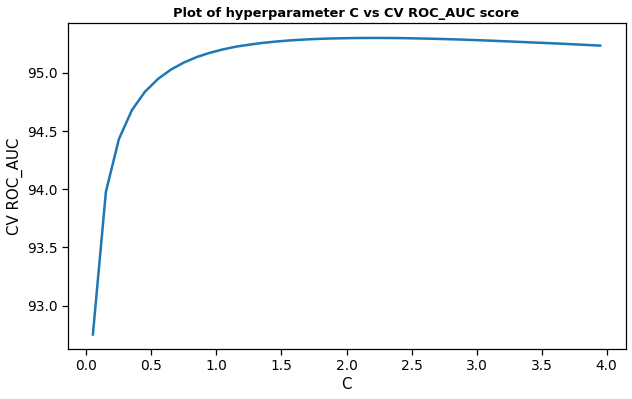

In [43]:
#Perform Cross - validation using user-defined function cross_val_3
cv_results = pd.DataFrame(columns=['val_Accuracy', 'val_ROC_AUC', 'C'])

C = np.arange(0.05, 4, 0.1)
for p in C:
    score_list = []
    cross_val_3(X_train, y_train, score_list, 'LogReg', p)
    cv_results = cv_results.append(pd.Series([(score_list[0][0] + score_list[1][0] + score_list[2][0])/3,
                                              (score_list[0][1] + score_list[1][1] + score_list[2][1])/3,
                                              p
                                             ], 
                                    index=['val_Accuracy', 'val_ROC_AUC', 'C']), ignore_index=True)
print(cv_results)
plt.xlabel("C")
plt.ylabel("CV ROC_AUC")
plt.plot(cv_results['C'], cv_results['val_ROC_AUC'])
plt.title("Plot of hyperparameter C vs CV ROC_AUC score",fontsize=13, fontweight='bold')
plt.show()

In [143]:
#GridSearchCV
param_grid = {'C': np.arange(0.05, 4, 0.1)}
lr = LogisticRegression()
gridSearch_lr = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc')
gridSearch_lr.fit(X_train, y_train)
print(gridSearch_lr.best_params_)
print(gridSearch_lr.best_score_)

{'C': 2.1500000000000004}
0.9533435268440519


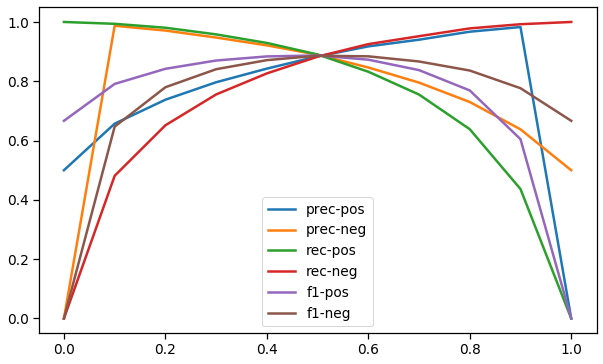

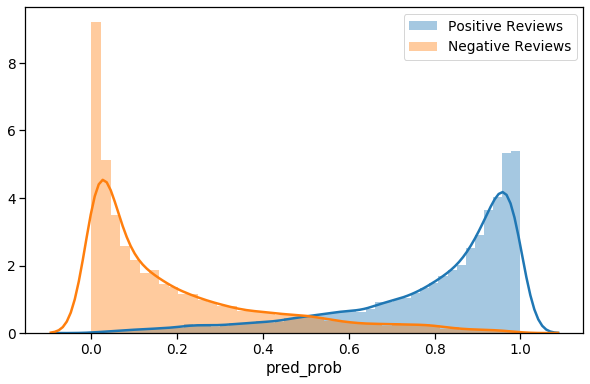

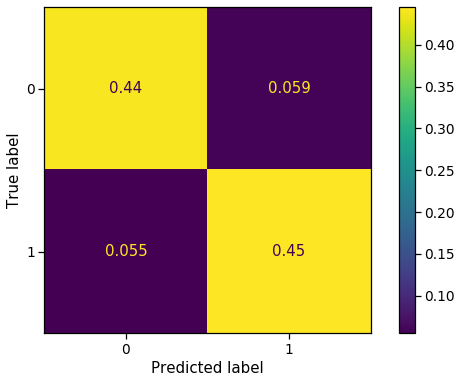

In [147]:
lr = LogisticRegression(C=2.05)

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)
plot_confusion_matrix(lr, X_test, y_test, normalize="all")
plt.show()

In [148]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.664,95.49024,0.887056,0.883815,0.89032,0.886221,0.889507,0.88296,0.411296,0.0035


## 4.2. Naive Bayes

   val_Accuracy  val_ROC_AUC  alpha
0     86.196026    93.606537   0.01
1     86.212025    93.606746   0.10
2     86.160026    93.592794   0.50
3     86.176023    93.580411   1.00
4     86.136019    93.553975   2.00
5     86.096016    93.525669   3.00
6     86.004017    93.496743   4.00
7     85.944016    93.467806   5.00
8     85.900015    93.336458  10.00


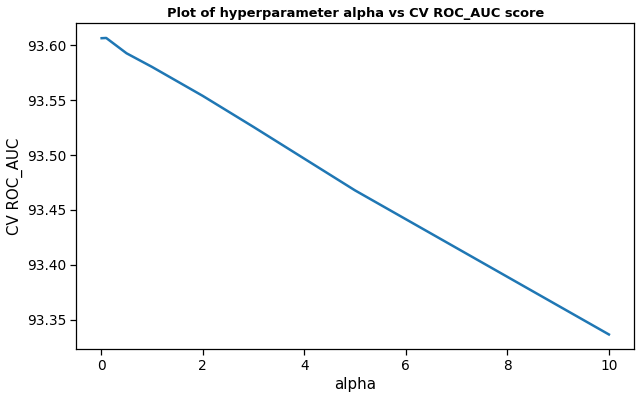

In [44]:
#Perform 3 fold cross validation and hyperparameter tuning
cv_results = pd.DataFrame(columns=['val_Accuracy', 'val_ROC_AUC', 'alpha'])
alpha = [0.01, 0.1, 0.5, 1, 2,3,4,5, 10]
for j in alpha:
    score_list = []
    cross_val_3(X_train, y_train, score_list, 'NaiveBayes', j)
    cv_results = cv_results.append(pd.Series([(score_list[0][0] + score_list[1][0] + score_list[2][0])/3,
                                              (score_list[0][1] + score_list[1][1] + score_list[2][1])/3, j
                                             ], 
                                    index=['val_Accuracy', 'val_ROC_AUC', 'alpha']), ignore_index=True)

print(cv_results)
plt.plot(cv_results['alpha'], cv_results['val_ROC_AUC'])
plt.title("Plot of hyperparameter alpha vs CV ROC_AUC score",fontsize=13, fontweight='bold')
plt.xlabel("alpha")
plt.ylabel("CV ROC_AUC")
plt.show()

In [151]:
#GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 2,3,4,5, 10]}
nb = MultinomialNB()
gridSearch_nb = GridSearchCV(nb, param_grid, cv=3, scoring='roc_auc')
gridSearch_nb.fit(X_train, y_train)

print(gridSearch_nb.best_params_)
print(gridSearch_nb.best_score_)

{'alpha': 0.1}
0.9363055540445853


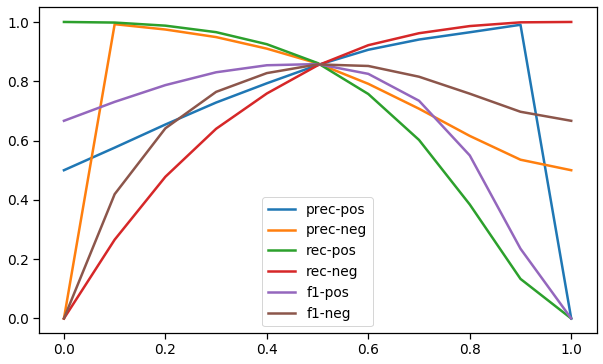

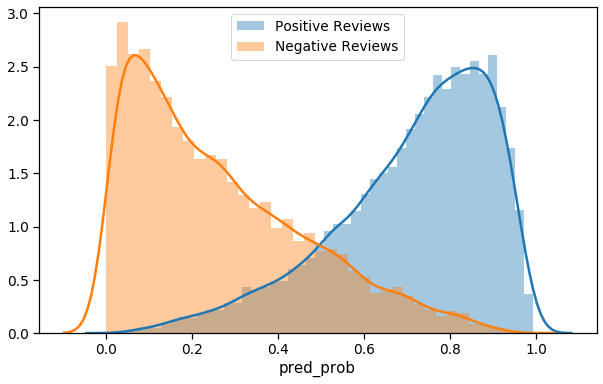

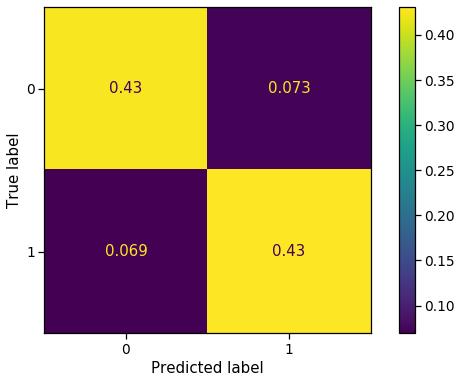

In [152]:
#fit the MultinomialNB model with best hyperparameter from cross-validation
nb = MultinomialNB(alpha=0.1)

fit_start = time.time()
nb.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = nb.predict(X_test)
predict_end = time.time()

y_pred_prob = nb.predict_proba(X_test)[:,1]

model_score('Naive Bayes',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)
plot_confusion_matrix(nb, X_test, y_test, normalize='all')
plt.show()

In [153]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.664,95.490240,0.887056,0.883815,0.89032,0.886221,0.889507,0.88296,0.411296,0.003500
1,Naive Bayes,85.744,93.201283,0.858008,0.854603,0.86144,0.856867,0.860323,0.85344,0.017628,0.010812


## 4.3. SVM

In [47]:
svmc = SVC(probability = True)

# Define a grid of hyperparameter 'params_rf'
params_svm = {'C': [0.1,1, 10, 100], 
             'gamma': [1,0.1,0.01,0.001],
             'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
             }

# Instantiate RandomSearchCV
randomSearch_svm = RandomizedSearchCV(estimator = svmc, param_distributions = params_svm,
                                      n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit to training set
randomSearch_svm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 76.3min remaining: 23.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 80.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=True, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf', 'poly', 'sigmoid',
                                                   'linear']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [48]:
best_model = randomSearch_svm.best_params_ 
print('Best hyerparameters:\n', best_model)

Best hyerparameters:
 {'kernel': 'rbf', 'gamma': 1, 'C': 1}


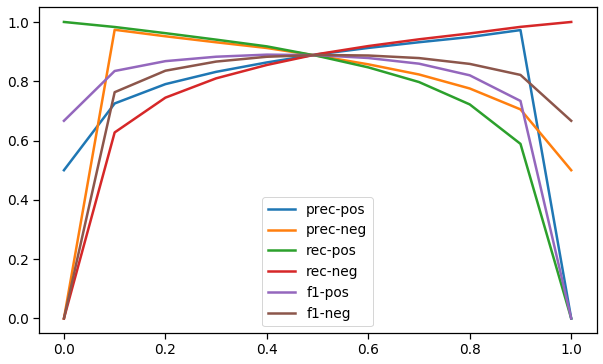

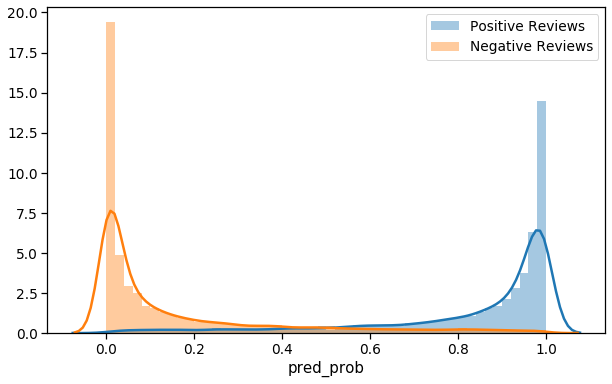

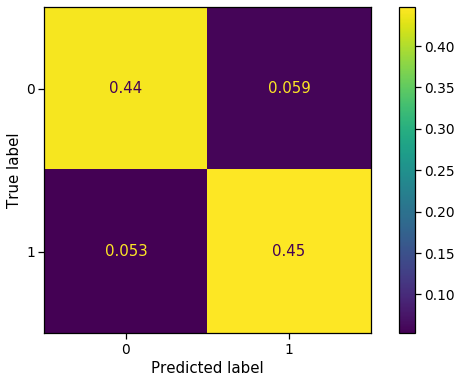

In [49]:
svmc = SVC(kernel='rbf', gamma=1, C=1, probability=True)

fit_start = time.time()
svmc.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = svmc.predict(X_test)
predict_end = time.time()

y_pred_prob = svmc.predict_proba(X_test)[:,1]

model_score('SVM',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )

threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(svmc, X_test, y_test, normalize='all')
plt.show()

In [50]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.688,95.496312,0.887313,0.883931,0.89072,0.886444,0.889874,0.88304,0.562575,0.004125
1,Naive Bayes,85.724,93.196101,0.857792,0.854489,0.86112,0.856684,0.860034,0.85336,0.015818,0.009561
2,SVM,88.812,95.546948,0.888792,0.883487,0.89416,0.887440,0.892866,0.88208,3397.451614,231.395614


## 4.4. Decision Tree

In [51]:
dt = DecisionTreeClassifier()

params_dt = {
#'max_depth': [3, 4,5, 6],
"max_depth": [10, 100, 1000, 10000],
"min_samples_split": [5, 10, 50, 100, 500, 1000],
"min_samples_leaf": [10, 100, 1000, 10000],
#'min_samples_leaf': [0.04, 0.06, 0.08],
"max_leaf_nodes": [10, 100, 1000, 10000],
'max_features': ['log2', 'sqrt', 'auto'],
'min_samples_split' : [10, 30, 50, 100]
}

grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring='roc_auc',
cv=10,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best CV score from 'grid_dt'
best_CV_score = grid_dt.best_score_
print('Best CV accuracy'.format(best_CV_score))


Best hyerparameters:
 {'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': 1000, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best CV accuracy


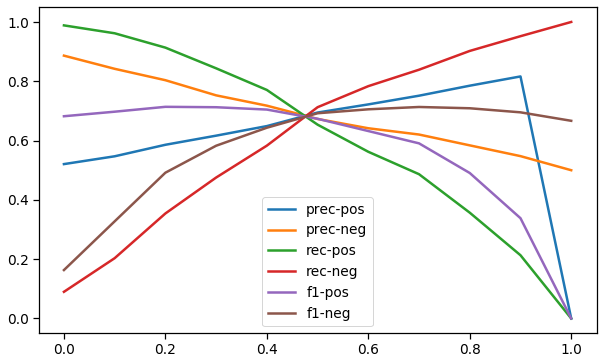

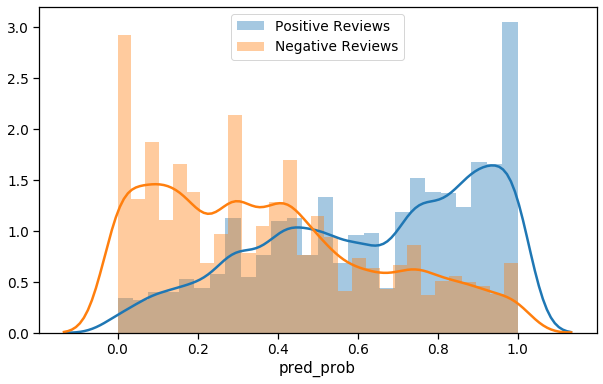

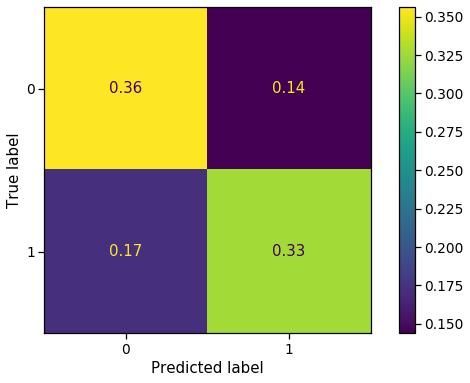

In [53]:
# Extract best model from 'grid_dt'
dt = grid_dt.best_estimator_

fit_start = time.time()
dt.fit(X_train,y_train)
fit_end = time.time()

#predict review label for test dataset
predict_start = time.time()
y_pred = dt.predict(X_test)
predict_end = time.time()

y_pred_prob = dt.predict_proba(X_test)[:,1]

model_score('Decision Tree',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)
plot_confusion_matrix(dt, X_test, y_test, normalize='all')
plt.show()

In [58]:
# model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
#                                                           'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.688,95.496312,0.887313,0.883931,0.89072,0.886444,0.889874,0.88304,0.562575,0.004125
1,Naive Bayes,85.724,93.196101,0.857792,0.854489,0.86112,0.856684,0.860034,0.85336,0.015818,0.009561
2,SVM,88.812,95.546948,0.888792,0.883487,0.89416,0.887440,0.892866,0.88208,3397.451614,231.395614
3,Decision Tree,67.624,73.903448,0.673128,0.679661,0.66672,0.679293,0.672947,0.68576,0.272437,0.020412


## 4.5. Random Forest

In [158]:
#hyperparameter tuning using RandomizedSearchCV
#Instantiate a random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs = -1)

# Define a grid of hyperparameter 'params_rf'
params_rf = {
    'n_estimators': [50, 100, 300, 500], 
    'min_samples_leaf': [5,10,20,30],
    'max_features': ['log2', 'sqrt', 'auto']
}

# Instantiate RandomSearchCV
randomSearch_rf = RandomizedSearchCV(estimator = rf, param_distributions = params_rf,
                                      n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit to training set
randomSearch_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   39.5s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [159]:
# Extract best hyperparameters from RandomizedSearchCV
best_model = randomSearch_rf.best_params_ 
print('Best hyerparameters:\n', best_model)

Best hyerparameters:
 {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


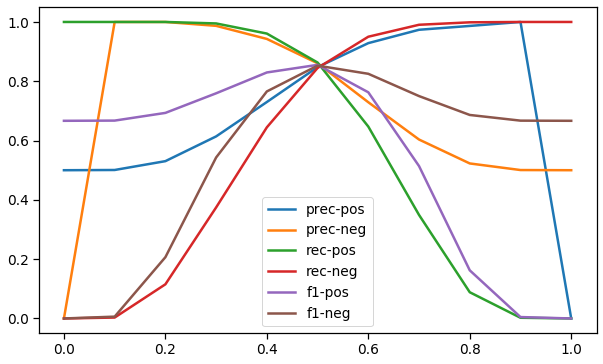

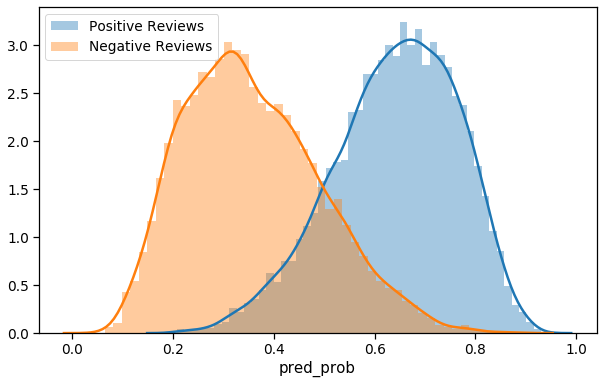

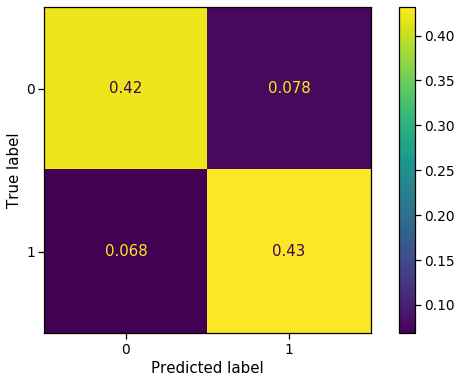

In [160]:
#Instantiate a classifier with the best hyperparameters 
rf = randomSearch_rf.best_estimator_

fit_start = time.time()
rf.fit(X_train,y_train)
fit_end = time.time()

#predict review label for test dataset
predict_start = time.time()
y_pred = rf.predict(X_test)
predict_end = time.time()

y_pred_prob = rf.predict_proba(X_test)[:,1]

model_score('Random Forest',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)
plot_confusion_matrix(rf, X_test, y_test, normalize='all')
plt.show()

In [66]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.688,95.496312,0.887313,0.883931,0.89072,0.886444,0.889874,0.88304,0.562575,0.004125
1,Naive Bayes,85.724,93.196101,0.857792,0.854489,0.86112,0.856684,0.860034,0.85336,0.015818,0.009561
2,SVM,88.812,95.546948,0.888792,0.883487,0.89416,0.887440,0.892866,0.88208,3397.451614,231.395614
3,Decision Tree,67.624,73.903448,0.673128,0.679661,0.66672,0.679293,0.672947,0.68576,0.272437,0.020412
4,Random Forest,85.404,93.029608,0.855365,0.847671,0.86320,0.852691,0.860647,0.84488,17.245649,0.927878


## 4.6. LightGBM

In [67]:
#Hyperparameter Tuning using RandomizedSearchCV
lgb = LGBMClassifier(objective='binary', boosting_type='gbdt',metric='auc', random_state=5)

params_lgb = {'learning_rate': [0.1, 0.01, 0.001],
               'num_leaves' : [30, 50],
               'min_data_in_leaf' : [20, 25, 30,50],
               'max_depth' : [10, 20, 30, 50],
               'min_gain_to_split' : [0.5, 0.8, 1.0],
               'lambda_l1' : [0, 1 ,10, 25, 50],
               'lambda_l2' : [0, 1 ,10, 25, 50],
               'max_bin' : [50, 100, 200, 250],
               'n_estimators': [250,  500, 1000, 1500],
               'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
               'subsample' : [0.2,0.4,0.6,0.8,1]
               }


# Instantiate RandomSearchCV
randomSearch_lgb = RandomizedSearchCV(estimator = lgb, param_distributions = params_lgb,
                                      n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit to training set
randomSearch_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  5.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='auc', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=5, reg_alpha=0.0,
                                            reg_l...
                                        'lambda_l2': [0, 1, 10, 25, 50],
                                        'learning_ra

In [68]:
# Extract best hyperparameters from RandomizedSearchCV
best_model = randomSearch_lgb.best_params_ 
print('Best hyerparameters:\n', best_model)

Best hyerparameters:
 {'subsample': 0.2, 'num_leaves': 30, 'n_estimators': 500, 'min_gain_to_split': 0.5, 'min_data_in_leaf': 20, 'max_depth': 20, 'max_bin': 250, 'learning_rate': 0.1, 'lambda_l2': 10, 'lambda_l1': 0, 'colsample_bytree': 1}


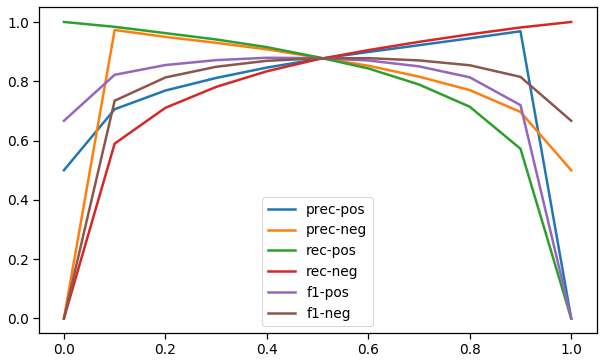

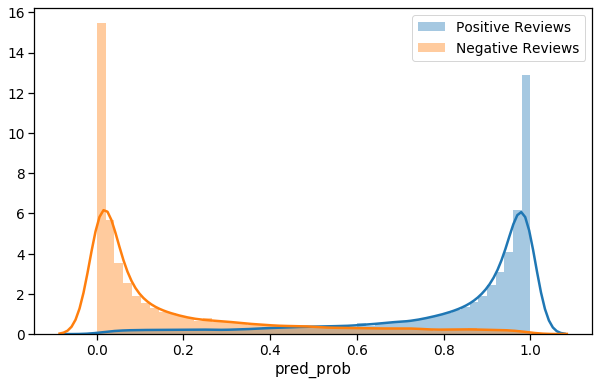

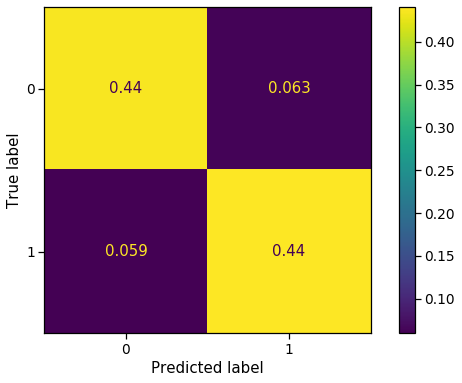

In [69]:
lgb = randomSearch_lgb.best_estimator_

fit_start = time.time()
lgb.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lgb.predict(X_test)
predict_end = time.time()

y_pred_prob = lgb.predict_proba(X_test)[:,1]

model_score( 'LightGBM' ,y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)

threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(lgb, X_test, y_test, normalize='all')
plt.show()

In [70]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg,88.688,95.496312,0.887313,0.883931,0.89072,0.886444,0.889874,0.88304,0.562575,0.004125
1,Naive Bayes,85.724,93.196101,0.857792,0.854489,0.86112,0.856684,0.860034,0.85336,0.015818,0.009561
2,SVM,88.812,95.546948,0.888792,0.883487,0.89416,0.887440,0.892866,0.88208,3397.451614,231.395614
3,Decision Tree,67.624,73.903448,0.673128,0.679661,0.66672,0.679293,0.672947,0.68576,0.272437,0.020412
4,Random Forest,85.404,93.029608,0.855365,0.847671,0.86320,0.852691,0.860647,0.84488,17.245649,0.927878
5,LightGBM,87.764,94.925628,0.878093,0.874851,0.88136,0.877183,0.880471,0.87392,40.206875,0.282701


# 5. Feature Selection Techniques

In [46]:
X_traindf = pd.DataFrame(X_train.toarray())
X_testdf = pd.DataFrame(X_test.toarray())
modelScore_list = []

## 5.1. feature_importances_ Attribute

In [162]:
rf.feature_importances_

array([1.39115889e-05, 1.31288290e-06, 4.14015102e-06, ...,
       1.65901828e-04, 5.20386356e-06, 0.00000000e+00])

In [163]:
#rf model used here is from the previous section
#Random Forest model's feature_importances_ attribute
rf_feature_PD = pd.DataFrame()
rf_feature_PD['feature'] = list(range(7957))
rf_feature_PD['importance'] = rf.feature_importances_

In [164]:
#We will first drop all the features with 0 feature importance and check the count of remaining features
rf_feature_PD.drop(rf_feature_PD[rf_feature_PD['importance'] == 0].index, inplace=True)
rf_feature_PD.shape

(6075, 2)

In [165]:
#Sort the feature importance values by descending order
rf_feature_PD.sort_values(by='importance', ascending=False, inplace=True)

In [166]:
#Get the features that together contributes to 95%
feature_95 = rf_feature_PD[rf_feature_PD['importance'].cumsum() <= 0.95].feature.values

In [178]:
X_train.shape

(25000, 7957)

In [167]:
#Selected features
feature_95.sort()
len(feature_95)

1386

In [141]:
# #Map the selected features index with the CountVectorizer words
# feature_names = count_vect.vocabulary_
# feature_names = { v:k for k,v in feature_names.items()}
# features_sel = [feature_names.get(item,item)  for item in feature_95]
# features_sel

In [168]:
#Keep only the selected features in train and test dataframe
X_train_FI = X_traindf[feature_95]
X_test_FI= X_testdf[feature_95]

In [169]:
print("Shape of Train dataset", X_train_FI.shape)
print("Shape of Test dataset", X_test_FI.shape)

Shape of Train dataset (25000, 1386)
Shape of Test dataset (25000, 1386)


In [170]:
#Build the Random Forest model on the selected features
#Instantiate a random forest classifier
rf_FI = RandomForestClassifier(random_state=42, n_jobs = -1)

# Define a grid of hyperparameter 'params_rf'
params_rf = {
    'n_estimators': [50, 100, 300, 500], 
    'min_samples_leaf': [5,10,20,30],
    'max_features': ['log2', 'sqrt', 'auto']
}

# Instantiate RandomSearchCV
randomSearch_rf = RandomizedSearchCV(estimator = rf_FI, param_distributions = params_rf,
                                      n_iter = 10, cv = 3, random_state=42, n_jobs = -1)

# Fit to training set
randomSearch_rf.fit(X_train_FI, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [171]:
# Extract best hyperparameters from RandomizedSearchCV
best_model = randomSearch_rf.best_params_ 
print('Best hyerparameters:\n', best_model)

Best hyerparameters:
 {'n_estimators': 50, 'min_samples_leaf': 10, 'max_features': 'log2'}


In [262]:
#Instantiate a classifier with the best hyperparameters 
rf_FI = randomSearch_rf.best_estimator_

fit_start = time.time()
rf_FI.fit(X_train_FI,y_train)
fit_end = time.time()

#predict review label for test dataset
predict_start = time.time()
y_pred = rf_FI.predict(X_test_FI)
predict_end = time.time()

y_pred_prob = rf_FI.predict_proba(X_test_FI)[:,1]

model_score('Random Forest - FI',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)

In [263]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Random Forest - FI,84.5,92.463971,0.846856,0.836835,0.85712,0.843098,0.853571,0.83288,1.807111,0.38771


## 5.2. Recursive Feature Elimination

In [265]:
#Note: Takes quite sometime, pickle file of the object is available in the repository
# Uses lr object from previous section
rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(2),scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Original number of features is %s' % X_train.shape[1])
print("RFECV final number of features : %d" % rfecv.n_features_)
print('')

Original number of features is 7957
RFECV final number of features : 6415



In [269]:
filename = "/Users/aru/DataScience/Projects/IMDB-Sentiment_Analysis/rfecv"
outfile = open(filename,'wb')
pickle.dump(rfecv,outfile)
outfile.close()

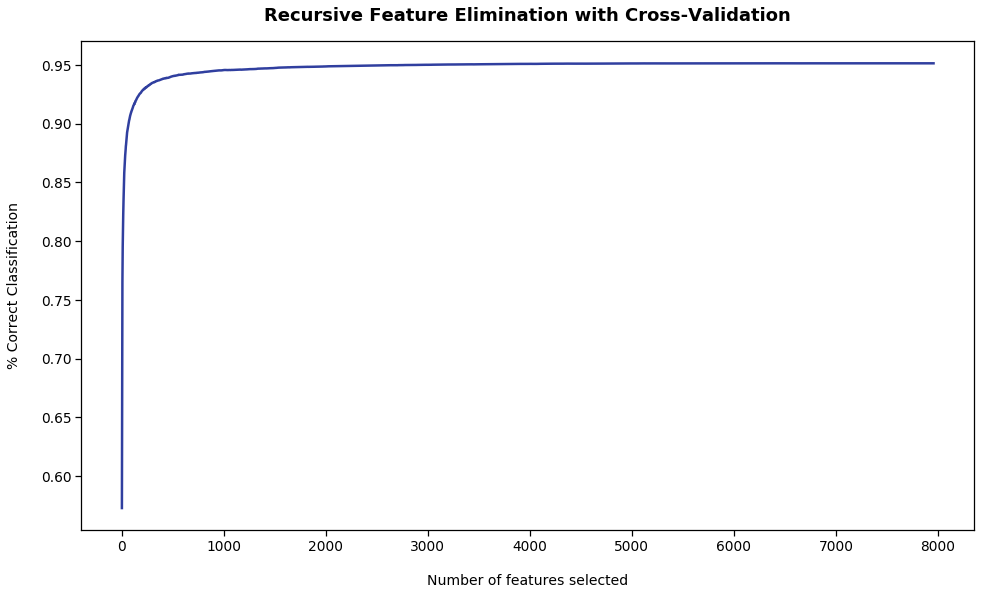

In [266]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F')
plt.show()

In [270]:
#Drop the unimportant features from train and test dataframe
X_train_Rfe = X_traindf.drop(X_traindf.columns[np.where(rfecv.support_ == False)[0]], axis=1)
X_test_Rfe = X_testdf.drop(X_testdf.columns[np.where(rfecv.support_ == False)[0]], axis=1)

In [271]:
print("Shape of Train dataset", X_train_Rfe.shape)
print("Shape of Test dataset", X_test_Rfe.shape)

Shape of Train dataset (25000, 6415)
Shape of Test dataset (25000, 6415)


In [272]:
#GridSearchCV
param_grid = {'C': np.arange(0.05, 2, 0.05)}
lr = LogisticRegression()
gridSearch_lr = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc')
gridSearch_lr.fit(X_train_Rfe, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])},
             pre_dispatch='2*n_jobs', refit=True, return_

In [274]:
print(gridSearch_lr.best_params_)
print(gridSearch_lr.best_score_)

{'C': 1.9500000000000002}
0.9575808162422762


In [278]:
modelScore_list = []
lr = LogisticRegression(C=1.95)

fit_start = time.time()
lr.fit(X_train_Rfe, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test_Rfe)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test_Rfe)[:,1]

model_score('Log Reg - RFE',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )

In [279]:
model_score_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
model_score_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - RFE,88.78,95.496225,0.888189,0.88512,0.89128,0.887408,0.890518,0.88432,9.933889,0.152012


# 6. Class Imbalance

In [130]:
modelScore_list = []
imdb_pos_train_5 = imdb_train[pos].sample(random_state=42, n=625)

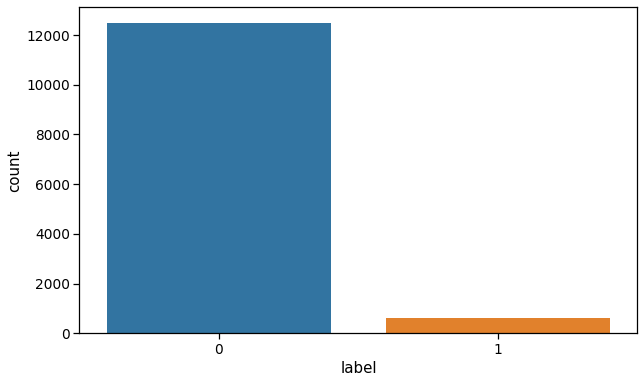

In [121]:
#Distrubution of positive and negative reviews in Train set
sns.countplot(x= 'label', data = pd.concat([imdb_pos_train_5, imdb_neg_train]))
plt.show()

In [122]:
imdb_train_5 = pd.concat([imdb_pos_train_5[['review_lemma','label']], imdb_train[neg][['review_lemma','label']]], 
                         ignore_index=True)
imdb_train_5 = imdb_train_5.sample(frac=1).reset_index(drop=True)

In [123]:
def count_vect(train, test):
    cv = CountVectorizer(min_df=50, ngram_range=(1,2))
    X_train_vect = cv.fit_transform(train['review_lemma'].values)
    X_test_vect = cv.transform(test['review_lemma'].values)
    
    tfidf_vect = TfidfTransformer()
    X_train = tfidf_vect.fit_transform(X_train_vect)
    X_test = tfidf_vect.transform(X_test_vect)

    y_train = train['label'].values
    y_test = test['label'].values
    
    return X_train, y_train, X_test, y_test

In [124]:
#X_train, y_train, X_test, y_test with imbalanced class data
X_train, y_train, X_test, y_test = count_vect(imdb_train_5, imdb_test)

In [125]:
#GridSearchCV for Logistic Regression
param_grid = {'C': np.arange(0.05, 2, 0.05)}
lr = LogisticRegression()
gridSearch_lr = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc')
gridSearch_lr.fit(X_train, y_train)

print(gridSearch_lr.best_params_)
print(gridSearch_lr.best_score_)

{'C': 1.9500000000000002}
0.9253522095670963


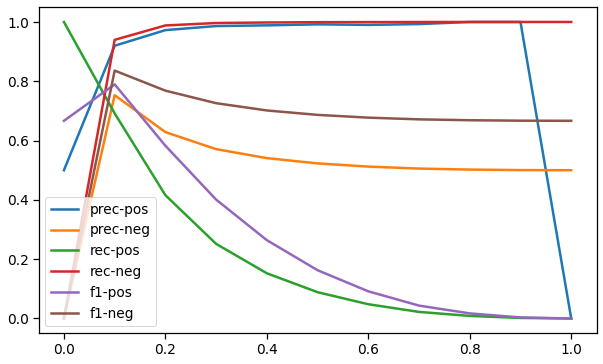

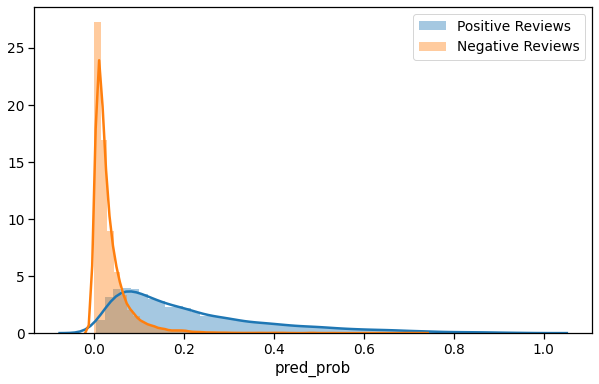

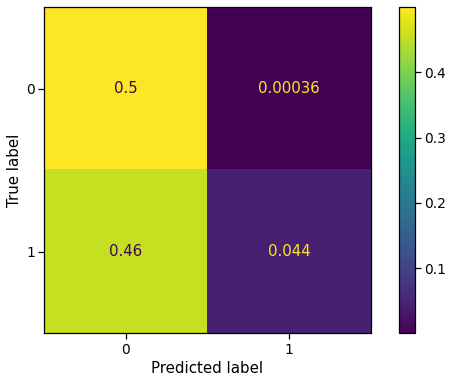

In [131]:
lr = LogisticRegression(C=1.95)

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()

In [132]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208


## 6.1. Class Weights

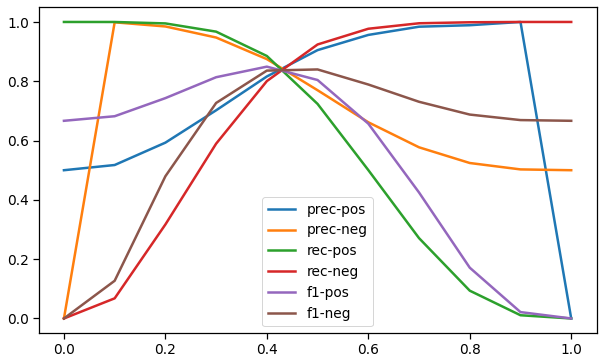

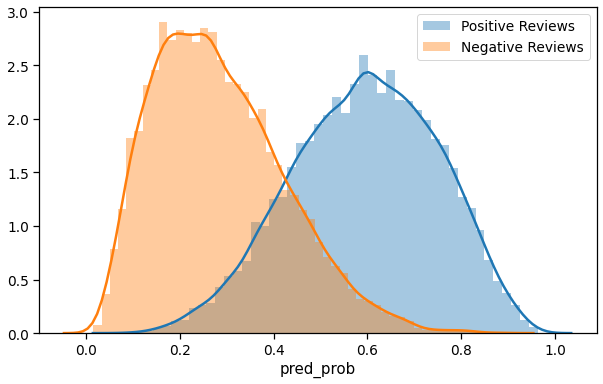

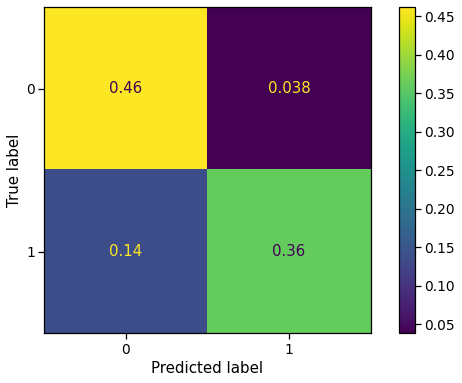

In [133]:
lr = LogisticRegression(C=1.95, class_weight =  {0:.05, 1:.95})

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI[class weights]',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()



In [134]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208
1,Log Reg - CI[class weights],82.384,92.523062,0.804214,0.905043,0.72360,0.839889,0.769759,0.92408,0.077754,0.004059


## 6.2. Resampling

### 6.2.1. Upsampling

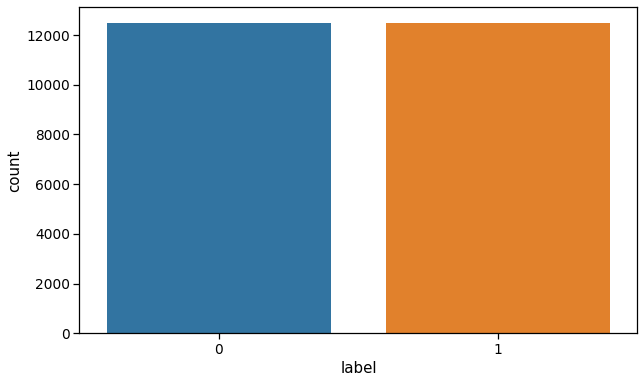

In [135]:
# Upsample minority class
df_minority_upsampled = resample(imdb_pos_train_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=12500,    # to match majority class
                                 random_state=123) # reproducible results

#Distrubution of positive and negative reviews in Train set
sns.countplot(x= 'label', data = pd.concat([df_minority_upsampled, imdb_neg_train]))
plt.show()

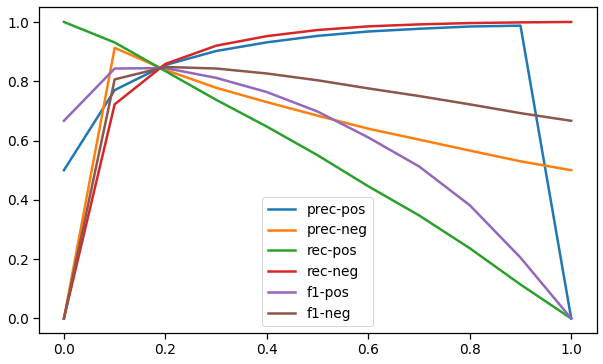

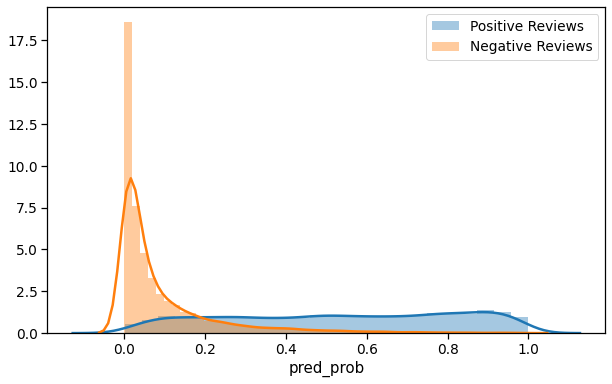

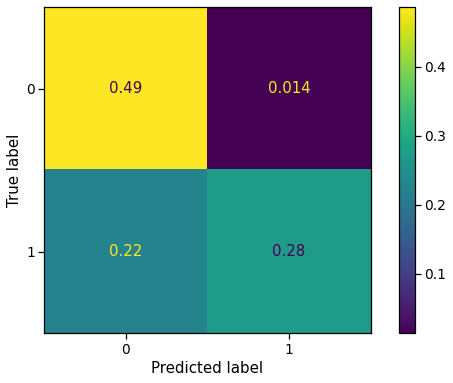

In [136]:
imdb_train_upsampled = pd.concat([df_minority_upsampled, imdb_train[neg]])
X_train, y_train, X_test, y_test = count_vect(imdb_train_upsampled, imdb_test)

lr = LogisticRegression(C=1.95)

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI[Upsample]',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list)
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()


In [137]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208
1,Log Reg - CI[class weights],82.384,92.523062,0.804214,0.905043,0.72360,0.839889,0.769759,0.92408,0.077754,0.004059
2,Log Reg - CI[Upsample],76.172,92.737350,0.697936,0.953054,0.55056,0.803263,0.684009,0.97288,0.673658,0.004904


### 6.2.2. Downsampling

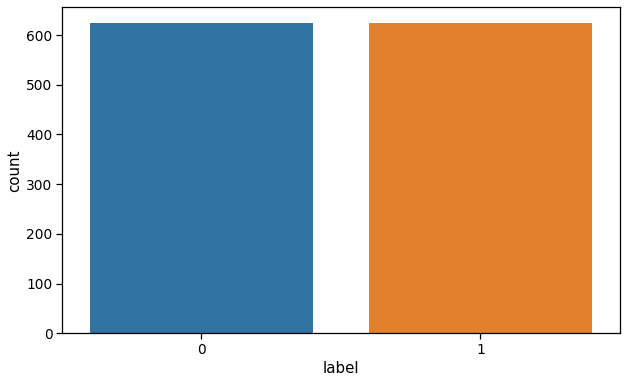

In [138]:
# Downsampling of  majority class
df_majority_downsampled = resample(imdb_train[neg], 
                                 replace=True,     
                                 n_samples=625,    
                                 random_state=123) 

#Distrubution of positive and negative reviews in Train set
sns.countplot(x= 'label', data = pd.concat([df_majority_downsampled, imdb_pos_train_5]))

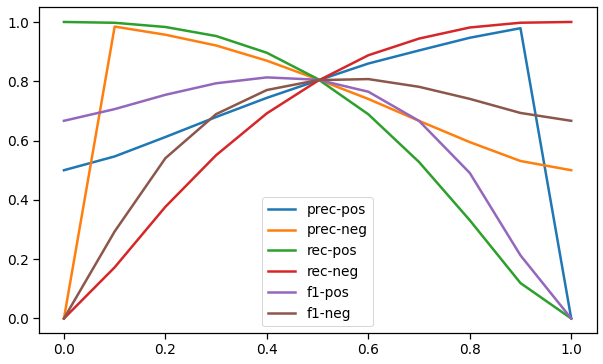

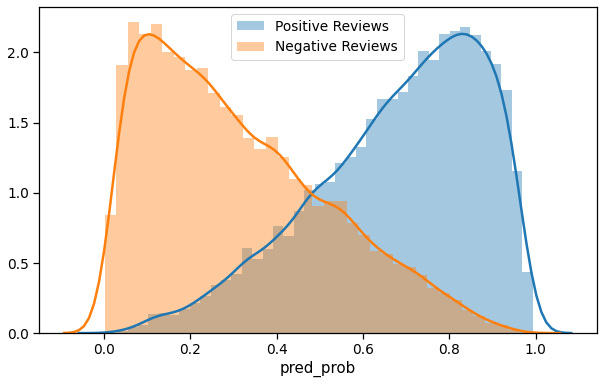

In [139]:
imdb_train_downsampled = pd.concat([df_majority_downsampled, imdb_pos_train_5])
X_train, y_train, X_test, y_test = count_vect(imdb_train_downsampled, imdb_test)

lr = LogisticRegression(C=1.95)

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI [downsample]',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

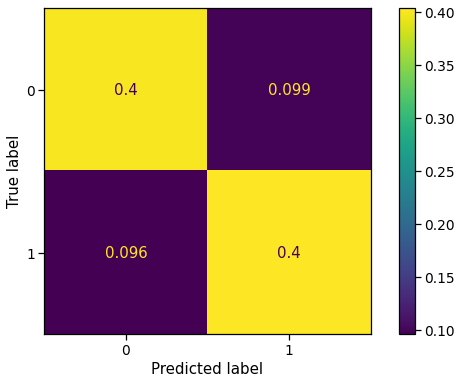

In [140]:
plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()

In [141]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208
1,Log Reg - CI[class weights],82.384,92.523062,0.804214,0.905043,0.72360,0.839889,0.769759,0.92408,0.077754,0.004059
2,Log Reg - CI[Upsample],76.172,92.737350,0.697936,0.953054,0.55056,0.803263,0.684009,0.97288,0.673658,0.004904
3,Log Reg - CI [downsample],80.452,88.904028,0.805198,0.802415,0.80800,0.803837,0.806654,0.80104,0.013698,0.003768


### 6.2.3. Downsample + Upsample

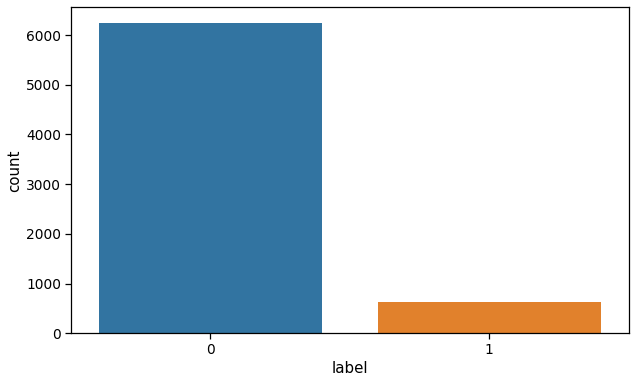

In [142]:
# Downsample majority class
df_majority_downsampled = resample(imdb_train[neg], 
                                 replace=True,     # sample with replacement
                                 n_samples=6250,    # to match half of majority class
                                 random_state=123) # reproducible results

#Distrubution of positive and negative reviews in Train set
sns.countplot(x= 'label', data = pd.concat([df_majority_downsampled, imdb_pos_train_5]))

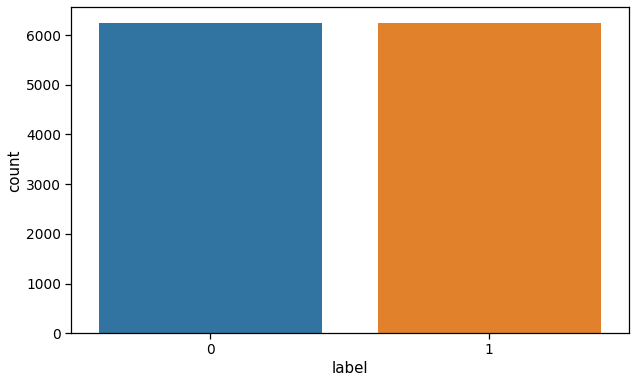

In [143]:
# Upsample minority class
df_minority_upsampled = resample(imdb_pos_train_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=6250,    # to match majority class
                                 random_state=123) # reproducible results

#Distrubution of positive and negative reviews in Train set
sns.countplot(x= 'label', data = pd.concat([df_majority_downsampled, df_minority_upsampled]))
plt.show()

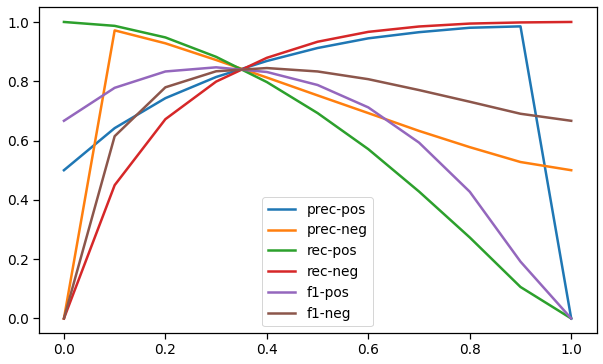

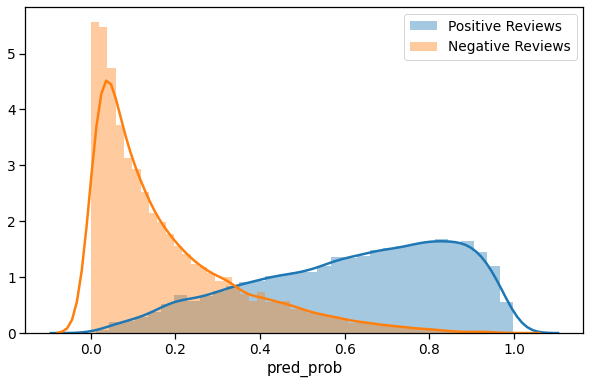

In [144]:
imdb_train_downup = pd.concat([df_majority_downsampled, df_minority_upsampled])
X_train, y_train, X_test, y_test = count_vect(imdb_train_downup, imdb_test)

lr = LogisticRegression(solver = 'liblinear', C=1)

fit_start = time.time()
lr.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI [down & up sample]',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

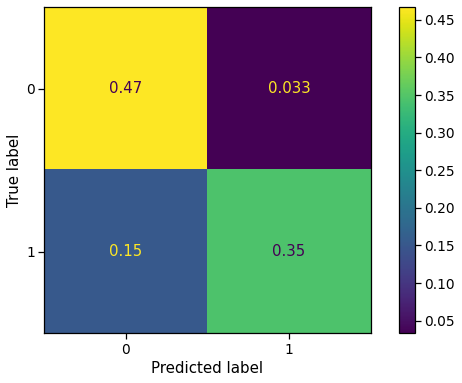

In [145]:
plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()

In [146]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208
1,Log Reg - CI[class weights],82.384,92.523062,0.804214,0.905043,0.72360,0.839889,0.769759,0.92408,0.077754,0.004059
2,Log Reg - CI[Upsample],76.172,92.737350,0.697936,0.953054,0.55056,0.803263,0.684009,0.97288,0.673658,0.004904
3,Log Reg - CI [downsample],80.452,88.904028,0.805198,0.802415,0.80800,0.803837,0.806654,0.80104,0.013698,0.003768
4,Log Reg - CI [down & up sample],81.300,92.436648,0.787432,0.912146,0.69272,0.833077,0.752305,0.93328,0.126920,0.004464


## SMOTE

In [149]:
#X_train, y_train, X_test, y_test with imbalanced class data
X_train, y_train, X_test, y_test = count_vect(imdb_train_5, imdb_test)
counter = collections.Counter(y_train)
print(counter)

Counter({0: 12500, 1: 625})


In [150]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)
counter = collections.Counter(y)
print(counter)

Counter({0: 12500, 1: 12500})


In [152]:
#GridSearchCV for Logistic Regression
param_grid = {'C': np.arange(0.05, 2, 0.05)}
lr = LogisticRegression()
gridSearch_lr = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc')
gridSearch_lr.fit(X, y)

print(gridSearch_lr.best_params_)
print(gridSearch_lr.best_score_)

{'C': 1.9500000000000002}
0.9964326117658704


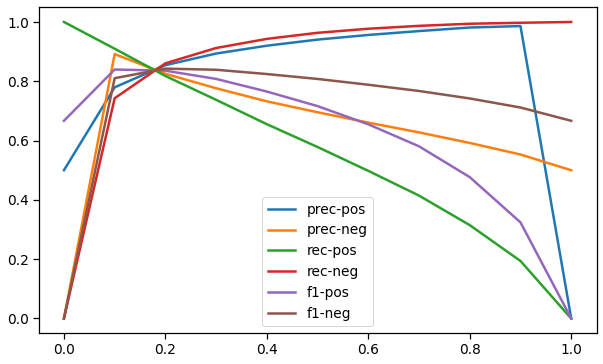

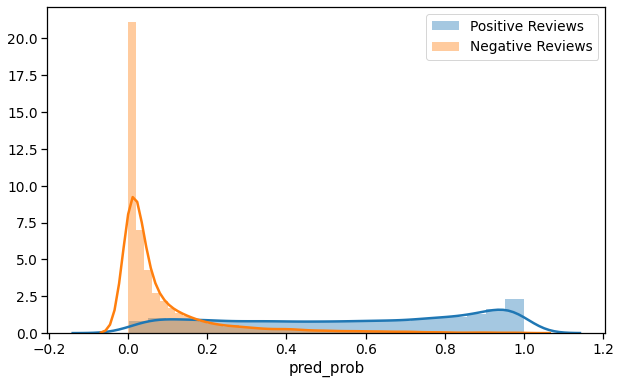

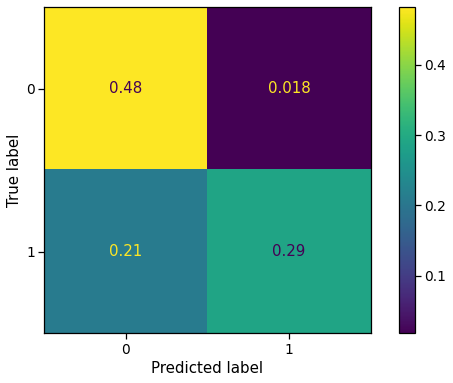

In [153]:
lr = LogisticRegression(C=1.95)

fit_start = time.time()
lr.fit(X, y)
fit_end = time.time()

predict_start = time.time()
y_pred = lr.predict(X_test)
predict_end = time.time()

#Evaluate the model's roc_auc_score
y_pred_prob = lr.predict_proba(X_test)[:,1]

model_score('Log Reg - CI[Smote]',y_pred, y_pred_prob, (fit_end - fit_start), (predict_end - predict_start), modelScore_list )
threshold_cfm(y_pred_prob)
prob_dist(y_pred_prob)

plot_confusion_matrix(lr, X_test, y_test, normalize='all')
plt.show()

In [154]:
resampling_pd = pd.DataFrame(modelScore_list, columns = ['Model', 'Accuracy(%)', 'ROC_AUC(%)', 'F1_1', 'Prec_1','Rec_1', 
                                                          'F1_0', 'Prec_0', 'Rec_0', 'Fit_Time(s)', 'Predict_Time(s)'])
resampling_pd

,Model,Accuracy(%),ROC_AUC(%),F1_1,Prec_1,Rec_1,F1_0,Prec_0,Rec_0,Fit_Time(s),Predict_Time(s)
0,Log Reg - CI,54.396,92.817063,0.162738,0.991943,0.08864,0.686639,0.523008,0.99928,0.270444,0.003208
1,Log Reg - CI[class weights],82.384,92.523062,0.804214,0.905043,0.72360,0.839889,0.769759,0.92408,0.077754,0.004059
2,Log Reg - CI[Upsample],76.172,92.737350,0.697936,0.953054,0.55056,0.803263,0.684009,0.97288,0.673658,0.004904
3,Log Reg - CI [downsample],80.452,88.904028,0.805198,0.802415,0.80800,0.803837,0.806654,0.80104,0.013698,0.003768
4,Log Reg - CI [down & up sample],81.300,92.436648,0.787432,0.912146,0.69272,0.833077,0.752305,0.93328,0.126920,0.004464
5,Log Reg - CI[Smote],77.084,92.149926,0.716175,0.940534,0.57824,0.807848,0.695524,0.96344,0.450146,0.004296
